In [10]:
from ingestion import make_cleaned, make_train_test
from metadata_helpers import save_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error


In [11]:
X_train, X_test, y_train, y_test = make_train_test()

categoric_cols = X_train.select_dtypes(include=object).columns.tolist()
OH_encoder = SklearnTransformerWrapper(transformer=OneHotEncoder(
    sparse_output=False, drop='if_binary', min_frequency=0.1, handle_unknown='ignore'), variables=categoric_cols)
pipe = make_pipeline(OH_encoder,
                     DecisionTreeRegressor(random_state=42))
depth_range = np.arange(1, 15)
gs = GridSearchCV(n_jobs=3, estimator=pipe, cv=10,
                  scoring='neg_root_mean_squared_error', param_grid={'decisiontreeregressor__max_depth': depth_range})


In [12]:
gs.fit(X_train, y_train)


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 32] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [15, 23] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sklearntransformerwrapper',
                                        SklearnTransformerWrapper(transformer=OneHotEncoder(drop='if_binary',
                                                                                            handle_unknown='ignore',
                                                                                            min_frequency=0.1,
                                                                                            sparse_output=False),
                                                                  variables=['MSSubClass',
                                                                             'MSZoning',
                                                                             'Street',
                                                                             'Alley',
                                                                             'LotShape',
                                                                             'LandContour',
                                                                             'Utilities',
                                                                             'LotConfig',
                                                                             'LandSlope',
                                                                             'Neighborhood',
                                                                             'Condition1',
                                                                             'Co...
                                                                             'Foundation',
                                                                             'BsmtExposure',
                                                                             'BsmtFinType1',
                                                                             'BsmtFinType2',
                                                                             'Heating',
                                                                             'CentralAir',
                                                                             'Electrical',
                                                                             'Functional',
                                                                             'GarageType',
                                                                             'GarageFinish',
                                                                             'PavedDrive', ...])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=3,
             param_grid={'decisiontreeregressor__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
             scoring='neg_root_mean_squared_error')

In [13]:
gs.best_params_


{'decisiontreeregressor__max_depth': 7}

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/en

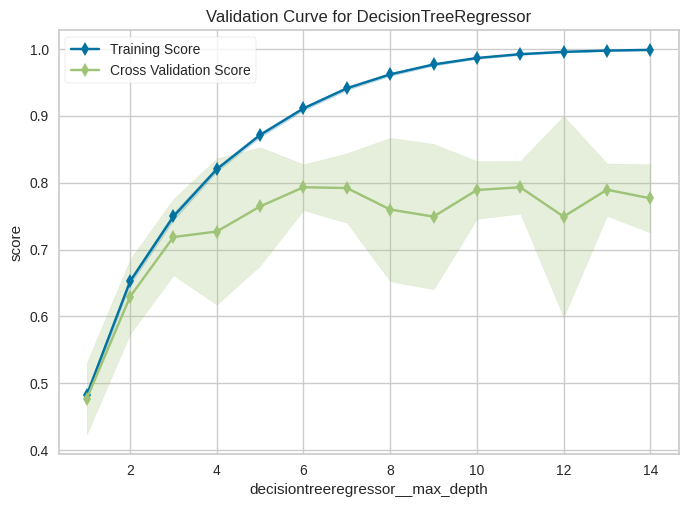

<AxesSubplot: title={'center': 'Validation Curve for DecisionTreeRegressor'}, xlabel='decisiontreeregressor__max_depth', ylabel='score'>

In [14]:
pipe_validation = make_pipeline(
    OH_encoder, DecisionTreeRegressor(random_state=42)
)
viz = ValidationCurve(
    pipe_validation, cv=10, param_name='decisiontreeregressor__max_depth', param_range=depth_range
)
# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 15, 16, 17, 18, 23, 25, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 15, 16, 17, 18, 23, 25, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


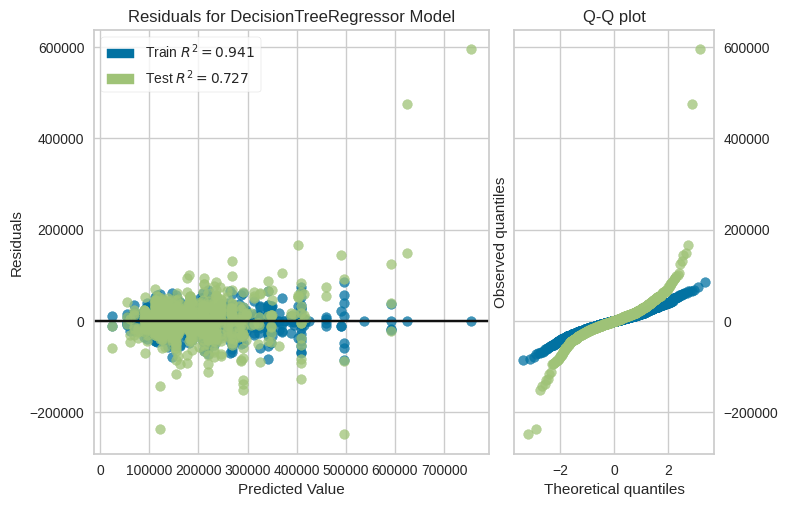

<AxesSubplot: title={'center': 'Residuals for DecisionTreeRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [15]:
# Validation suggested max_depth 11, but 7 had a similar value and gave better generalizability to the test set.
pipe_final = make_pipeline(
    OH_encoder, DecisionTreeRegressor(random_state=42, max_depth=7)
)
visualizer = ResidualsPlot(pipe_final, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


In [16]:
rmse_test = mean_squared_error(
    pipe_final.predict(X_test), y_test, squared=False)
print(f"rmse = {rmse_test}")


rmse = 41756.96851386337


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 15, 16, 17, 18, 23, 25, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [17]:
save_score({'decisiontreeregressor__max_depth': str(
    pipe_final._final_estimator.get_params()['max_depth'])}, rmse_test)


# Plot first few levels of tree

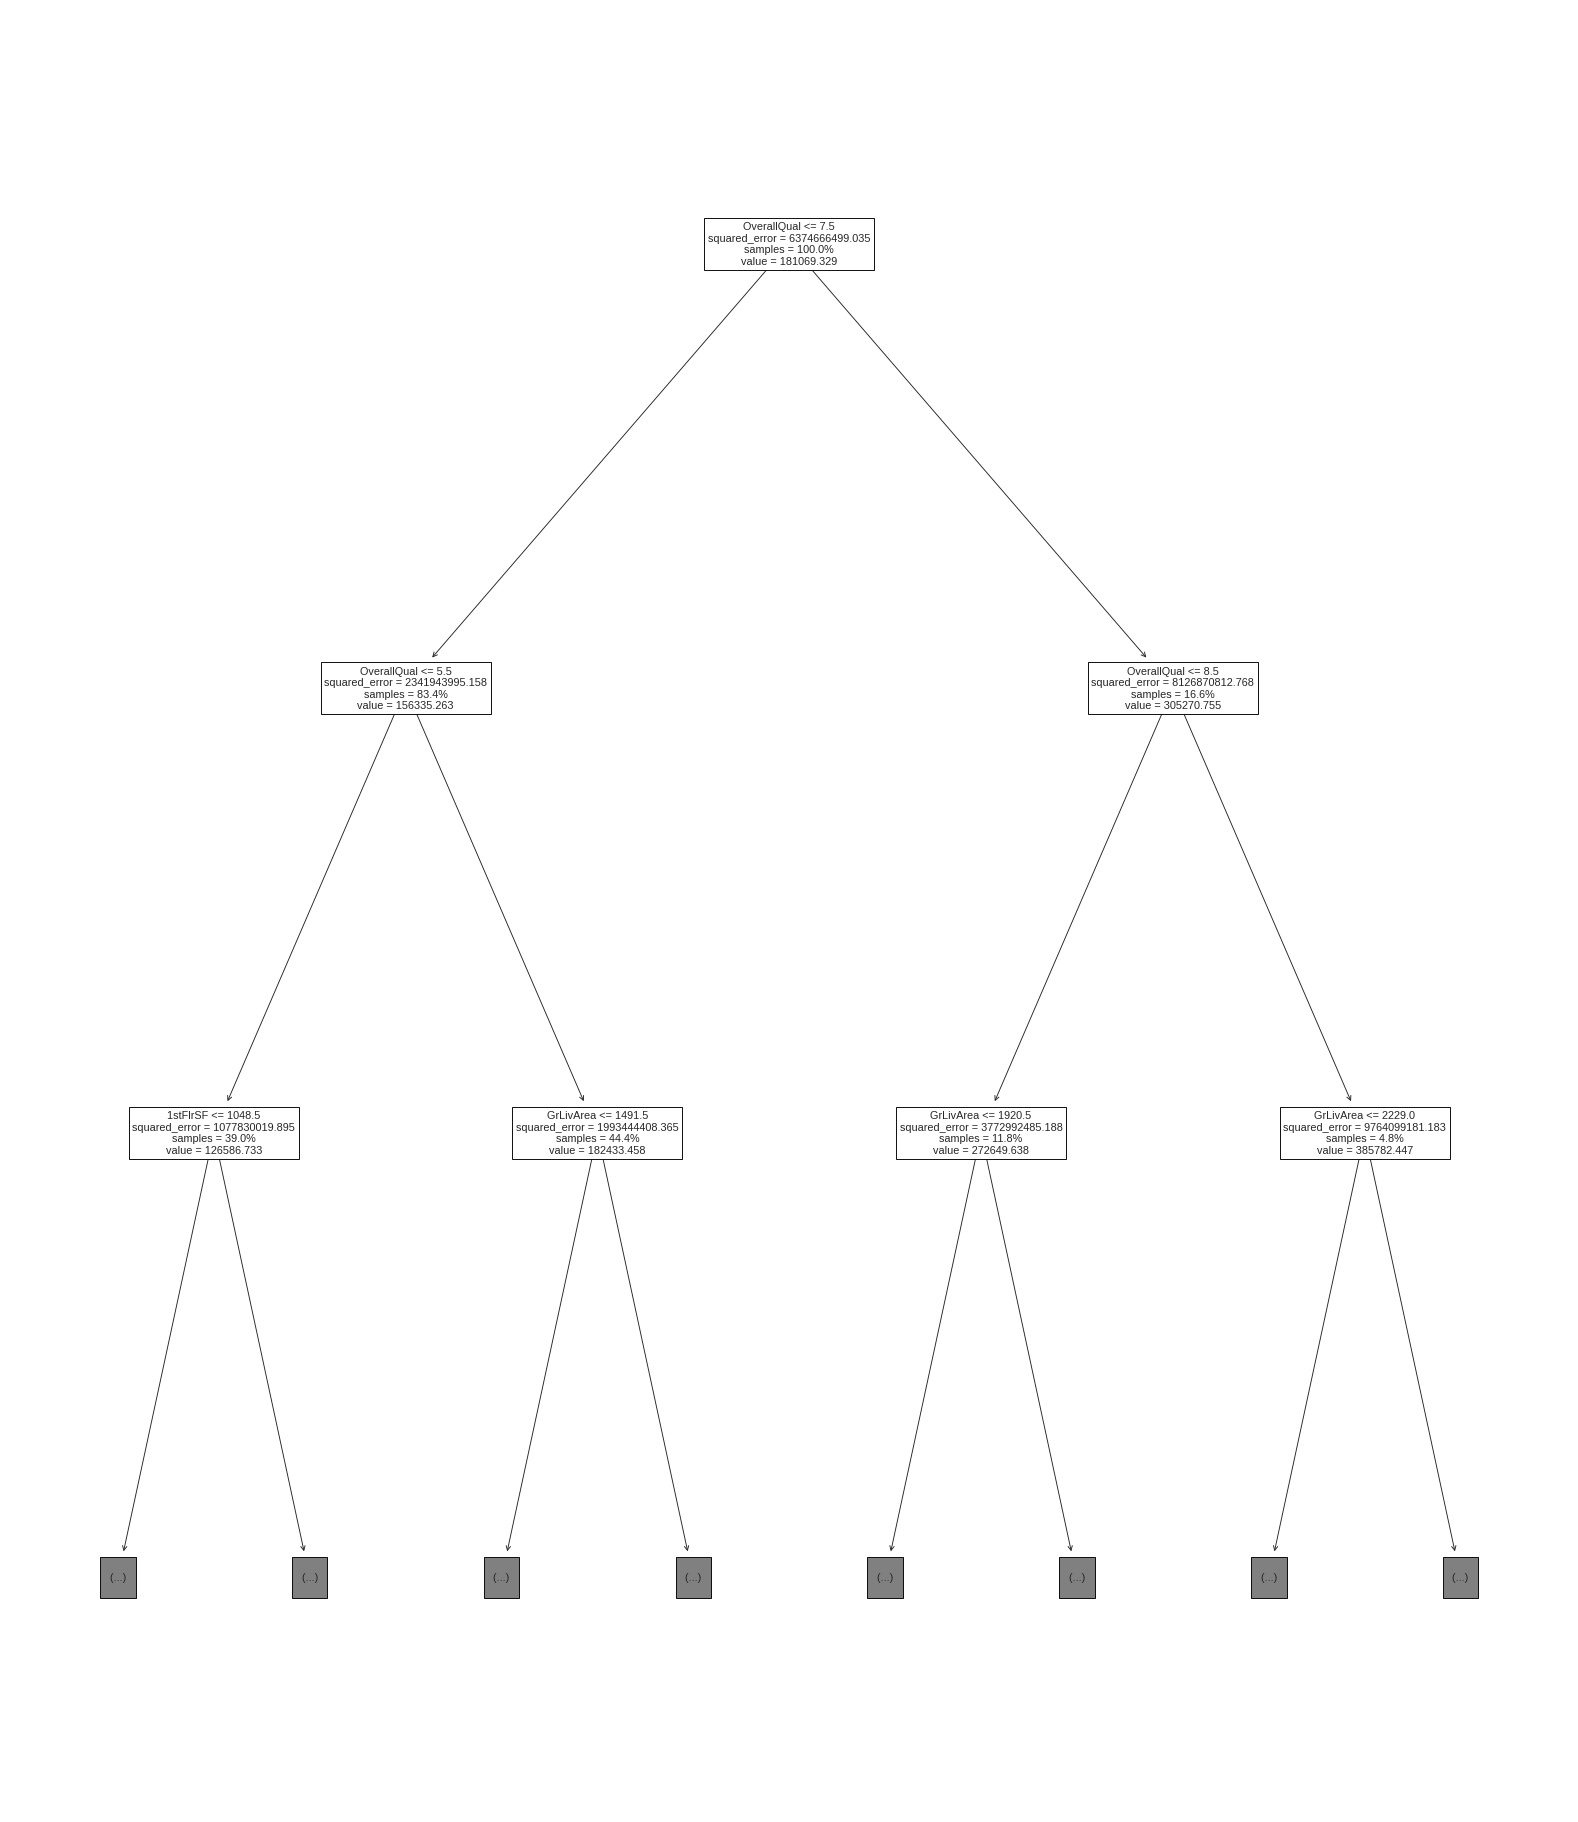

In [18]:
from sklearn.tree import plot_tree
plot_tree(decision_tree=pipe_final._final_estimator, max_depth=2,
          proportion=True, feature_names=pipe_final._final_estimator.feature_names_in_,)
fig = plt.gcf()
fig.set_size_inches(9, 10.5)
fig.set_dpi(220)
